
DATA 603 – Big Data Platforms

Homework #11 ML + AWS

Write a Spark ML-lib program to predict flight delays for certain airline UMAIR. UMAIR operates throughout the US. 

In [1]:
from pyspark import SparkContext 
from pyspark.sql import SQLContext
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.util import MLUtils
from pyspark.ml.feature import OneHotEncoder, StringIndexer, StandardScaler, Imputer, VectorAssembler, SQLTransformer
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml.linalg import Vectors

In [2]:
#generate random data for flights of size about 100 rows.

import random
from datetime import date, time
import csv

list_airport_code=['ABE', 'ABI', 'BWI', 'CAE', 'CDC', 'PHL', 'LAX', 'JFK']

# random Day generator
def generate_date():

    start_dt = date.today().replace(day=1, month=1, year=2019).toordinal()
    end_dt = date.today().toordinal()
    random_day = date.fromordinal(random.randint(start_dt, end_dt))
    return random_day

# random Time generator
def generate_time():
    hours = random.randint(3,23)
    minutes= random.randint(0,59)
    
    t1 = time(hours-(random.randint(0,2)), minutes) #flight schedule land time
    t2 = time(hours, minutes) # flight actual land time
    
    format = "%H:%M"
    #format datetime using strftime()
    start_time = t1.strftime(format)
    end_time= t2.strftime(format)
    
    return [start_time, end_time]

 
#Final function
def createFakeData(name_of_file, number_of_rows):
    with open (name_of_file, 'w', newline='') as file:
        writeData = csv.writer(file)

        #The headers
        writeData.writerow(['Flight No', 
                            'Date', 
                            'Time',
                            'Actual Date',
                            'Actual Time', 
                            'Origin',
                            'Destination'])
        
        for i in range(1,number_of_rows):
            
            day=generate_date()
            time=generate_time()
            aiport_codes = random.sample(list_airport_code, 2)
            
            writeData.writerow(['UM-'+ str(random.randint(400,799)+i),
                                 day, 
                                 time[0] ,
                                 day,
                                 time[1],
                                 aiport_codes[0],
                                 aiport_codes[1]
                               ])
                                
                                
    #print('You created a CSV file: ' + str(name_of_file) + ' with ' + str(number_of_rows) + ' rows.' )
            
createFakeData('FlightData.csv', 101)                                 

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName('flights delay').getOrCreate()

In [4]:
from pyspark.ml.regression import LinearRegression

In [5]:
# Load training data
df1 = spark.read.csv("FlightData.csv", header='true', inferSchema='false')
#spark.read.format("csv").load("FlightData.csv")
df1.show(5)

+---------+----------+-----+-----------+-----------+------+-----------+
|Flight No|      Date| Time|Actual Date|Actual Time|Origin|Destination|
+---------+----------+-----+-----------+-----------+------+-----------+
|   UM-794|2019-08-31|12:06| 2019-08-31|      12:06|   CAE|        ABE|
|   UM-749|2020-05-12|16:05| 2020-05-12|      16:05|   CDC|        ABE|
|   UM-498|2019-10-25|15:46| 2019-10-25|      16:46|   JFK|        CDC|
|   UM-786|2020-07-03|22:52| 2020-07-03|      23:52|   ABE|        CDC|
|   UM-780|2019-11-16|12:55| 2019-11-16|      13:55|   CAE|        LAX|
+---------+----------+-----+-----------+-----------+------+-----------+
only showing top 5 rows



In [6]:
df1.printSchema()

root
 |-- Flight No: string (nullable = true)
 |-- Date: string (nullable = true)
 |-- Time: string (nullable = true)
 |-- Actual Date: string (nullable = true)
 |-- Actual Time: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Destination: string (nullable = true)



In [7]:
# Sort the dataframe in descending- sort by a single colunm

df2 = df1.orderBy('Date', ascending=False)
df2.show(5)

+---------+----------+-----+-----------+-----------+------+-----------+
|Flight No|      Date| Time|Actual Date|Actual Time|Origin|Destination|
+---------+----------+-----+-----------+-----------+------+-----------+
|   UM-479|2020-07-11|16:39| 2020-07-11|      18:39|   JFK|        CDC|
|   UM-470|2020-07-10|20:33| 2020-07-10|      20:33|   PHL|        CDC|
|   UM-649|2020-07-07|06:07| 2020-07-07|      08:07|   CAE|        JFK|
|   UM-710|2020-07-03|19:46| 2020-07-03|      20:46|   JFK|        ABE|
|   UM-786|2020-07-03|22:52| 2020-07-03|      23:52|   ABE|        CDC|
+---------+----------+-----+-----------+-----------+------+-----------+
only showing top 5 rows



In [8]:

#Change columns type
for d in df2.columns:
    if d in ["Date", "Actual Date"]:
    # add condition for the cols to be type cast
       df2=df2.withColumn(d, df2[d].cast(DateType()))

In [9]:
df2.printSchema()

root
 |-- Flight No: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Time: string (nullable = true)
 |-- Actual Date: date (nullable = true)
 |-- Actual Time: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Destination: string (nullable = true)



In [10]:
#df2.show(5)

In [11]:
#df2.printSchema()

In [12]:
#df2.describe().show()

In [13]:
# define timedelta function (obtain delay duration in minutes)
from pyspark.sql.functions import udf

def time_delta(y,x): 
    from datetime import datetime
    end = datetime.strptime(y, '%H:%M')
    start = datetime.strptime(x, '%H:%M')
    delta = (end-start).seconds
    return delta

# register as a UDF 
f = udf(time_delta, IntegerType())

# Apply function
df_new = df2.withColumn('Delay Duration', f(df2["Actual Time"], df2["Time"])/60)

In [14]:
df_new.show(5)

+---------+----------+-----+-----------+-----------+------+-----------+--------------+
|Flight No|      Date| Time|Actual Date|Actual Time|Origin|Destination|Delay Duration|
+---------+----------+-----+-----------+-----------+------+-----------+--------------+
|   UM-479|2020-07-11|16:39| 2020-07-11|      18:39|   JFK|        CDC|         120.0|
|   UM-470|2020-07-10|20:33| 2020-07-10|      20:33|   PHL|        CDC|           0.0|
|   UM-649|2020-07-07|06:07| 2020-07-07|      08:07|   CAE|        JFK|         120.0|
|   UM-786|2020-07-03|22:52| 2020-07-03|      23:52|   ABE|        CDC|          60.0|
|   UM-710|2020-07-03|19:46| 2020-07-03|      20:46|   JFK|        ABE|          60.0|
+---------+----------+-----+-----------+-----------+------+-----------+--------------+
only showing top 5 rows



In [15]:
df_new.describe().show()

+-------+---------+-----+-----------+------+-----------+------------------+
|summary|Flight No| Time|Actual Time|Origin|Destination|    Delay Duration|
+-------+---------+-----+-----------+------+-----------+------------------+
|  count|      100|  100|        100|   100|        100|               100|
|   mean|     null| null|       null|  null|       null|              60.6|
| stddev|     null| null|       null|  null|       null|50.087196694637164|
|    min|   UM-432|01:14|      03:14|   ABE|        ABE|               0.0|
|    max|   UM-873|23:56|      23:56|   PHL|        PHL|             120.0|
+-------+---------+-----+-----------+------+-----------+------------------+



In [16]:
df_new.printSchema()

root
 |-- Flight No: string (nullable = true)
 |-- Date: date (nullable = true)
 |-- Time: string (nullable = true)
 |-- Actual Date: date (nullable = true)
 |-- Actual Time: string (nullable = true)
 |-- Origin: string (nullable = true)
 |-- Destination: string (nullable = true)
 |-- Delay Duration: double (nullable = true)



### Use OneHotEncoder to encode my categorical data.

In [17]:
 # Category Indexing with StringIndexer

stringIndexer = StringIndexer(inputCol = "Origin", outputCol = "Origin"+ 'Index')
df_new= stringIndexer.fit(df_new).transform(df_new)
#indexer.show(5) 

stringIndexer = StringIndexer(inputCol = "Destination", outputCol = "Destination"+ 'Index')
df_new= stringIndexer.fit(df_new).transform(df_new)
df_new.show(5) 


+---------+----------+-----+-----------+-----------+------+-----------+--------------+-----------+----------------+
|Flight No|      Date| Time|Actual Date|Actual Time|Origin|Destination|Delay Duration|OriginIndex|DestinationIndex|
+---------+----------+-----+-----------+-----------+------+-----------+--------------+-----------+----------------+
|   UM-479|2020-07-11|16:39| 2020-07-11|      18:39|   JFK|        CDC|         120.0|        0.0|             0.0|
|   UM-470|2020-07-10|20:33| 2020-07-10|      20:33|   PHL|        CDC|           0.0|        3.0|             0.0|
|   UM-649|2020-07-07|06:07| 2020-07-07|      08:07|   CAE|        JFK|         120.0|        4.0|             6.0|
|   UM-786|2020-07-03|22:52| 2020-07-03|      23:52|   ABE|        CDC|          60.0|        1.0|             0.0|
|   UM-710|2020-07-03|19:46| 2020-07-03|      20:46|   JFK|        ABE|          60.0|        0.0|             2.0|
+---------+----------+-----+-----------+-----------+------+-----------+-

In [18]:
# Convert the dependent variable(Delay Duration) into dependent variable indices using the StringIndexer
dependent_stringIndexer = StringIndexer(inputCol = "Delay Duration", outputCol = "Delay Duration"+ 'Index')
df_new = dependent_stringIndexer.fit(df_new).transform(df_new)
df_new.show(5)

+---------+----------+-----+-----------+-----------+------+-----------+--------------+-----------+----------------+-------------------+
|Flight No|      Date| Time|Actual Date|Actual Time|Origin|Destination|Delay Duration|OriginIndex|DestinationIndex|Delay DurationIndex|
+---------+----------+-----+-----------+-----------+------+-----------+--------------+-----------+----------------+-------------------+
|   UM-479|2020-07-11|16:39| 2020-07-11|      18:39|   JFK|        CDC|         120.0|        0.0|             0.0|                0.0|
|   UM-470|2020-07-10|20:33| 2020-07-10|      20:33|   PHL|        CDC|           0.0|        3.0|             0.0|                1.0|
|   UM-649|2020-07-07|06:07| 2020-07-07|      08:07|   CAE|        JFK|         120.0|        4.0|             6.0|                0.0|
|   UM-786|2020-07-03|22:52| 2020-07-03|      23:52|   ABE|        CDC|          60.0|        1.0|             0.0|                2.0|
|   UM-710|2020-07-03|19:46| 2020-07-03|      20

In [19]:
# Use OneHotEncoder to convert categorical variables into binary SparseVectors

encoder = OneHotEncoderEstimator(inputCols=["DestinationIndex"], outputCols=["DestinationVec"], dropLast=False)


In [20]:
model = encoder.fit(df_new)
df_new= model.transform(df_new)
#df_new.show(5)

In [21]:
encoder = OneHotEncoderEstimator(inputCols=["OriginIndex"], outputCols=["OriginVec"], dropLast=False)

In [22]:
model1 = encoder.fit(df_new)
df_new= model1.transform(df_new)
df_new.show(5)

+---------+----------+-----+-----------+-----------+------+-----------+--------------+-----------+----------------+-------------------+--------------+-------------+
|Flight No|      Date| Time|Actual Date|Actual Time|Origin|Destination|Delay Duration|OriginIndex|DestinationIndex|Delay DurationIndex|DestinationVec|    OriginVec|
+---------+----------+-----+-----------+-----------+------+-----------+--------------+-----------+----------------+-------------------+--------------+-------------+
|   UM-479|2020-07-11|16:39| 2020-07-11|      18:39|   JFK|        CDC|         120.0|        0.0|             0.0|                0.0| (8,[0],[1.0])|(8,[0],[1.0])|
|   UM-470|2020-07-10|20:33| 2020-07-10|      20:33|   PHL|        CDC|           0.0|        3.0|             0.0|                1.0| (8,[0],[1.0])|(8,[3],[1.0])|
|   UM-649|2020-07-07|06:07| 2020-07-07|      08:07|   CAE|        JFK|         120.0|        4.0|             6.0|                0.0| (8,[6],[1.0])|(8,[4],[1.0])|
|   UM-786

In [23]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler


In [24]:
# Transform all features into a vector using VectorAssembler

featureassembler = VectorAssembler().setInputCols(["OriginVec", "DestinationVec"]).setOutputCol("Independent Features")
output1 = featureassembler.transform(df_new)
output1.show(5)

+---------+----------+-----+-----------+-----------+------+-----------+--------------+-----------+----------------+-------------------+--------------+-------------+--------------------+
|Flight No|      Date| Time|Actual Date|Actual Time|Origin|Destination|Delay Duration|OriginIndex|DestinationIndex|Delay DurationIndex|DestinationVec|    OriginVec|Independent Features|
+---------+----------+-----+-----------+-----------+------+-----------+--------------+-----------+----------------+-------------------+--------------+-------------+--------------------+
|   UM-479|2020-07-11|16:39| 2020-07-11|      18:39|   JFK|        CDC|         120.0|        0.0|             0.0|                0.0| (8,[0],[1.0])|(8,[0],[1.0])|(16,[0,8],[1.0,1.0])|
|   UM-470|2020-07-10|20:33| 2020-07-10|      20:33|   PHL|        CDC|           0.0|        3.0|             0.0|                1.0| (8,[0],[1.0])|(8,[3],[1.0])|(16,[3,8],[1.0,1.0])|
|   UM-649|2020-07-07|06:07| 2020-07-07|      08:07|   CAE|        JFK

In [25]:
 finalize_data = output1.select("Independent Features","Delay Duration")

In [26]:
finalize_data.show()

+--------------------+--------------+
|Independent Features|Delay Duration|
+--------------------+--------------+
|(16,[0,8],[1.0,1.0])|         120.0|
|(16,[3,8],[1.0,1.0])|           0.0|
|(16,[4,14],[1.0,1...|         120.0|
|(16,[1,8],[1.0,1.0])|          60.0|
|(16,[0,10],[1.0,1...|          60.0|
|(16,[0,8],[1.0,1.0])|          60.0|
|(16,[7,12],[1.0,1...|          60.0|
|(16,[1,12],[1.0,1...|         120.0|
|(16,[2,15],[1.0,1...|         120.0|
|(16,[4,13],[1.0,1...|           0.0|
|(16,[0,8],[1.0,1.0])|           0.0|
|(16,[6,8],[1.0,1.0])|           0.0|
|(16,[0,9],[1.0,1.0])|           0.0|
|(16,[2,12],[1.0,1...|          60.0|
|(16,[4,9],[1.0,1.0])|          60.0|
|(16,[7,8],[1.0,1.0])|           0.0|
|(16,[2,10],[1.0,1...|           0.0|
|(16,[3,8],[1.0,1.0])|           0.0|
|(16,[0,11],[1.0,1...|          60.0|
|(16,[0,11],[1.0,1...|          60.0|
+--------------------+--------------+
only showing top 20 rows



In [35]:
train_data, test_data = finalize_data.randomSplit([0.88, 0.12], seed = 100)
print("Training Dataset Count: " + str(train_data.count()))
print("Test Dataset Count: " + str(test_data.count()))

Training Dataset Count: 89
Test Dataset Count: 11


In [36]:
#Create an instance of our model using the given columns and also instantiate a prediction named column for our predictions
lin_reg=LinearRegression(featuresCol='Independent Features',labelCol='Delay Duration', predictionCol='prediction')
lin_reg = lin_reg.fit(train_data)


In [37]:
lin_reg.coefficients

DenseVector([-3.7943, -4.01, -14.0408, 1.0868, 8.1722, -5.373, -3.0212, 41.3046, -12.5762, -12.9647, -18.4923, 25.8401, 4.1976, -12.5486, 16.6553, 32.9827])

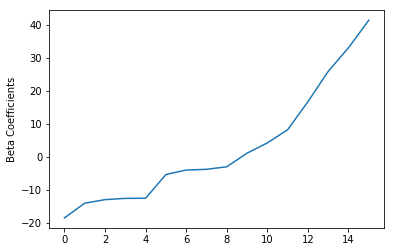

In [38]:
# Visualizing the coefficients

import matplotlib.pyplot as plt
import numpy as np
beta = np.sort(lin_reg.coefficients)
plt.plot(beta)
plt.ylabel('Beta Coefficients')
plt.show()

In [39]:
#Make predictions on the test set.

predictions = lin_reg.transform(test_data)
predictions.select('Independent Features','Delay Duration','prediction').show()

+--------------------+--------------+-----------------+
|Independent Features|Delay Duration|       prediction|
+--------------------+--------------+-----------------+
|(16,[0,10],[1.0,1...|          60.0| 39.6469556161622|
|(16,[1,12],[1.0,1...|         120.0|62.12126430407105|
|(16,[7,8],[1.0,1.0])|           0.0|90.66196873437889|
|(16,[3,8],[1.0,1.0])|           0.0|50.44416883227251|
|(16,[1,9],[1.0,1.0])|           0.0|44.95888078953659|
|(16,[7,11],[1.0,1...|          60.0|129.0782906752908|
|(16,[1,15],[1.0,1...|           0.0| 90.9062978918785|
|(16,[1,9],[1.0,1.0])|           0.0|44.95888078953659|
|(16,[1,13],[1.0,1...|         120.0|45.37506187309671|
|(16,[7,9],[1.0,1.0])|         120.0|90.27346634906368|
|(16,[1,12],[1.0,1...|         120.0|62.12126430407105|
+--------------------+--------------+-----------------+



In [40]:
lin_reg.intercept

61.93357324773695

In [41]:
#Summarize the model over the training set
trainingSummary = lin_reg.summary

In [42]:
#Some probability calculations

print(trainingSummary.meanAbsoluteError)
print(trainingSummary.rootMeanSquaredError)
print(trainingSummary.r2)

39.306987685139134
45.110436902702304
0.16089606391935152
